In [102]:
import numpy as np
import pandas as pd
from random import sample
from IPython.display import clear_output
from matplotlib import pyplot as plt

In [103]:
# def move_agents(SuSca, Agents): # N_alive, V, S, M, x, y
#     """
#     Function to move the agents on the sugarscape.
#     Implements one round where all the agents move once.
    
#     Parameters
#     ==========
#     SuSca : Lattice representing the Sugarscape. 
#     N_alive : Number of alive agents.
#     V : Vision. 1-d numpy array.
#     S : Sugar. 1-d numpy array.
#     M : Metabolism. 1-d numpy array.
#     x : x-position on the lattice of the agents. 1-d numpy array.
#     y : y-position on the lattice of the agents. 1-d numpy array.
#     """
#     N_alive = Agents["Alive?"].sum() #

#     SuSca_y, SuSca_x = SuSca.shape
    
#     nSuSca = SuSca.copy()
#     # print(nSuSca)
#     # nx = x.copy()
#     # ny = y.copy()
#     # nS = S.copy()

#     New_Agents = Agents.copy() #

#     Alive_indices = np.where(Agents["Alive?"]==True)[0]
#     Alive_x = New_Agents["X position"][Alive_indices]
#     Alive_y = New_Agents["X position"][Alive_indices]
    

#     # print(len(Alive_indices))
    
#     # Define the order of the agents in this round.   
#     order = np.random.permutation(Alive_indices)
#     # print("Order: ", order)
    
#     # For each agent: move it in the range of the vision.
    
#     for i, na in enumerate(Alive_indices):
#         ia = order[i]
        
#         # Agent current position.
#         # xa = nx[ia]
#         # ya = ny[ia]
#         # ma = M[ia]  # Metabolic rate.
#         # va = V[ia]  # Vision.
#         # sa = nS[ia]  # Available sugar/energy amount.
#         xa = New_Agents["X position"][ia]
#         ya = New_Agents["Y position"][ia]
#         ma = New_Agents["Metabolic Rate"][ia]  # Metabolic rate.
#         va = New_Agents["Vision"][ia]  # Vision.
#         sa = New_Agents["Sugar Level"][ia]  # Available sugar/energy amount.
        
#         # print(va)
#         # print(xa)
#         # Cells within the range of the agent.
#         rx = np.zeros(va * 4 + 1) + xa
#         ry = np.zeros(va * 4 + 1) + ya

#         # First position is the current agents
#         rx[0] = xa
#         ry[0] = ya

#         # Covers all cardinal directions
#         rx[0 * va + 1:1 * va + 1] = xa + np.arange(va) + 1
#         rx[1 * va + 1:2 * va + 1] = xa - np.arange(va) - 1
#         ry[2 * va + 1:3 * va + 1] = ya + np.arange(va) + 1
#         ry[3 * va + 1:4 * va + 1] = ya - np.arange(va) - 1

#         # Wrapping around boundaries
#         rx = rx.astype(int) % SuSca_x
#         ry = ry.astype(int) % SuSca_y

#         # print("rx", rx)
#         # print("ry", ry)
#         sugar = nSuSca[ry, rx]        
#         max_sugar = np.amax(sugar)
#         searching_new_pos = True
#         sugar_level = int(max_sugar)

#         # print("\n")
#         # print(f"Agent: {ia}, pos: {int(xa),int(ya)}")
#         # print(list(map(int, (nSuSca[ry, rx]))))
#         # print(rx)
#         # print(ry)
#         # print("Max sugar", sugar_level)
        
#         # Agent looks for the best available position.
#         while searching_new_pos:
#             # Search options for a certain sugar level.
#             options = np.where(sugar == sugar_level)[0]
            
            
#             # For each option, check whether position is already occupied.            
#             io = 0
#             place_found = False

#             while (io < np.size(options)) and (not place_found):
#                 i = options[io]
#                 x_ref = rx[i] % SuSca_x
#                 y_ref = ry[i] % SuSca_y

#                 # Check if the position is available.
#                 a_ref = np.intersect1d(
#                     np.where(New_Agents.iloc[Alive_indices, 0] == x_ref)[0],
#                     np.where(New_Agents.iloc[Alive_indices, 1] == y_ref)[0])
                
#                 if np.size(a_ref) == 0:
#                     # Position is available
#                     New_Agents.iloc[ia, 0] = x_ref 
#                     New_Agents.iloc[ia, 1] = y_ref
#                     New_Agents.iloc[ia, 4] += nSuSca[y_ref, x_ref]  # Agent takes the sugar.
#                     nSuSca[y_ref, x_ref] = 0   # Sugarscape cell is depleted.
#                     place_found = True
#                 else:
#                     # Check whether this is the current position.
#                     if (x_ref == New_Agents["X position"][ia]) and (y_ref == New_Agents["Y position"][ia]):
#                         New_Agents.iloc[ia, 4] += nSuSca[y_ref, x_ref]  # Agent takes the sugar.
#                         nSuSca[y_ref, x_ref] = 0   # Sugarscape cell is depleted.
#                         place_found = True
#                     else:
#                         # The position is occupied by someone else.
#                         io += 1
            
#             # If we are here, we either have found a place or 
#             # exausted the possibilities for this sugar_level
            
#             if not place_found:
#                 if sugar_level > 0:
#                     sugar_level -= 1
#                 else:
#                     # The agent stays where it is.                    
#                     New_Agents.iloc[ia, 4] += nSuSca[New_Agents["Y position"][ia], New_Agents["X position"][ia]]  # Agent takes the sugar.
#                     nSuSca[New_Agents["Y position"][ia], New_Agents["X position"][ia]] = 0
#                     searching_new_pos = False
#             else: 
#                 # A place has been found for the agent.
#                 searching_new_pos = False
#         # print(nSuSca[New_Agents["Y position"][ia], New_Agents["X position"][ia]] )
            
#         # print("New pos: ", x_ref,y_ref)
            
        
    
#     # All agents have moved.
    
#     # Now pay the metabolic price.
#     New_Agents.iloc[Alive_indices, 4] = New_Agents.iloc[Alive_indices, 4] - New_Agents.iloc[Alive_indices, 2]
    
#     # Now check which agents are still alive.
#     # still_alive = np.where(nS > 0)[0]
    
#     # N_still_alive = np.size(still_alive)
#     # V_alive = V[still_alive]
#     # S_alive = nS[still_alive]
#     # M_alive = M[still_alive]
#     # x_alive = nx[still_alive]
#     # y_alive = ny[still_alive]

#     not_alive = np.where(New_Agents["Sugar Level"] <= 0)[0]
#     New_Agents.iloc[not_alive, 5] = False
        
#     return nSuSca, New_Agents #N_still_alive, V_alive, S_alive, M_alive, x_alive, y_alive




Initialize the sugarscape in the "classical" way.

In [104]:
def initialize_sugarscape(N):
    """
    Function to generate the "classical" sugarscape.
    
    Parameters
    ==========
    N : Side of the sugarscape lattice.
    """
    
    SuSca = np.zeros([N, N])
    X, Y = np.meshgrid(np.arange(N), np.arange(N))
    
    x_centers = np.array([N / 4, 3 * N / 4])
    y_centers = np.array([N / 4, 3 * N / 4])

    r_levels = np.array([4, 3, 2, 1]) / 4 * (np.sqrt(2) / 4) * N
    s_levels = np.array([1, 2, 3, 4])
    
    for k in range(np.size(x_centers)):
        d = np.sqrt((X - x_centers[k]) ** 2 +
                    (Y - y_centers[k]) ** 2)
        for i in range(np.size(s_levels)):
            region = np.where(d <= r_levels[i])
            SuSca[region[0], region[1]] = s_levels[i]
    
    return SuSca


Function to convert a 2 dimensional numpy array into a RGB image.

In [105]:
def convert2RBG(SuSca, RGB0, RGB1):
    """
    Function to convert the 2 dimensional numpy array into a RGB image.
    
    Parameters
    ==========
    game_outcome : Outcome of the prisoner's dilemma.
    RGB0 : Components R, G, B of the chosen color shade for minimum I_profile.
    RGB1 : Components R, G, B of the chosen color shade for maximum I_profile.
    """
    game_outcome = SuSca.copy()
    
    [n_rows, n_cols] = game_outcome.shape
    
    I_RGB = np.zeros([n_rows, n_cols, 3])
    
    # Set I_profile between 0 and 1
    game_outcome -= np.amin(game_outcome)    
    game_outcome /= np.amax(game_outcome)  
    
    for c in range(3):
        I_RGB[:, :, c] = game_outcome * RGB1[c] + (1 - game_outcome) * RGB0[c]

    return I_RGB

Check whether the initialization works.

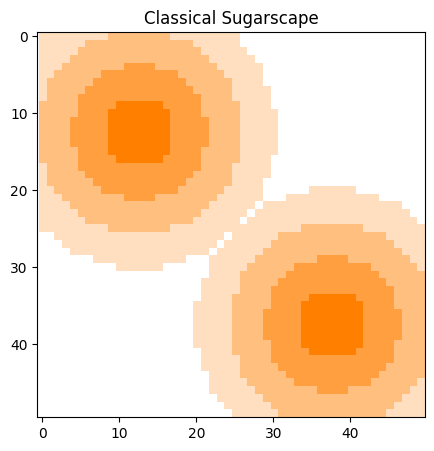

In [106]:
from matplotlib import pyplot as plt

N = 50  # Side of the sugarscape.

SuSca = initialize_sugarscape(N)

# Create the image of the game outcome.
RGB1 = [1.0, 0.5, 0.0]  # Orange. Color for high values.
RGB0 = [1.0, 1.0, 1.0]  # White. Color for low values.
SuSca_RGB = convert2RBG(SuSca, RGB0, RGB1)

# Plot the Sugarscape.
plt.figure(figsize=(5, 5))
plt.imshow(SuSca_RGB)  # Plot Sugarscape profile.
# Plot the reference points.
plt.title('Classical Sugarscape')
plt.axis('equal')
plt.show()       


In [107]:


# N = 50  # Size of the sugarscape with the agents.
# A = 400  # Number of agents on the sugarscape.

# # Initial values. Chosen from the following flat distributions.
# possible_m = np.arange(4) + 1  # Metabolic rate.
# possible_v = np.arange(6) + 1  # Vision.
# possible_s = np.arange(21) + 5  # Sugar.

# # Agents initialized. 
# M = np.random.randint(np.size(possible_m), size=A) + 1
# V = np.random.randint(np.size(possible_v), size=A) + 1
# S = np.random.randint(np.size(possible_s), size=A) + 5

# # Define agents position. 
# L = np.array(sample(range(N * N), A)).astype(int) 
# x = L % N
# y = ((L - x) / N).astype(int) 
# # This way each agent occupy a different cell.

# SuSca = initialize_sugarscape(N)

In [108]:
# import time 
# from tkinter import Tk
# from tkinter import Canvas

# r0 = 0.25
# N_skip = 1

# # Visualize status every N_skip steps. 
# window_size = 600

# cell_color_list = ['#FFFFFF', '#FFECCE', '#FFCE88', '#FFA040', '#FF8000']

# tk = Tk()
# tk.geometry(f'{window_size + 20}x{window_size + 20}')
# tk.configure(background='#000000')

# canvas = Canvas(tk, background='#ECECEC')  # Generate animation window.
# tk.attributes('-topmost', 0)
# canvas.place(x=10, y=10, height=window_size, width=window_size)

# step = 0

# def stop_loop(event):
#     global running
#     running = False
# tk.bind("<Escape>", stop_loop)  # Bind the Escape key to stop the loop.
# running = True  # Flag to control the loop.
# while running:

#     nSuSca, nA, nV, nS, nM, nx, ny = move_agents(SuSca, A, V, S, M, x, y)

#     # Update animation frame.
#     if step % N_skip == 0:        
#         canvas.delete('all')
#         SU_cells = []
#         for i in range(N):
#             for j in range(N):
#                 cell_color = cell_color_list[int(nSuSca[i, j])]
#                 #
#                 SU_cells.append(
#                     canvas.create_rectangle(
#                         i / N * window_size, 
#                         j / N * window_size,
#                         (i + 1) / N * window_size,
#                         (j + 1) / N * window_size, 
#                         outline='', 
#                         fill=cell_color,
#                     )
#                 )
#         Agents_circ = []
#         for i in range(nA):
#             Agents_circ.append(
#                 canvas.create_oval(
#                     (nx[i] + 0.5 - r0) / N * window_size, 
#                     (ny[i] + 0.5 - r0) / N * window_size,
#                     (nx[i] + 0.5 + r0) / N * window_size,
#                     (ny[i] + 0.5 + r0) / N * window_size, 
#                     outline='', 
#                     fill='#000000',
#                 )
#             )
        
#         tk.title(f'Iteration {step}')
#         tk.update_idletasks()
#         tk.update()
#         time.sleep(0.1)  # Increase to slow down the simulation.

#     A = nA
#     V = nV.copy()
#     S = nS.copy()
#     M = nM.copy()
#     x = nx.copy()
#     y = ny.copy()
#     step += 1
    
# tk.update_idletasks()
# tk.update()
# tk.mainloop()  # Release animation handle (close window to finish).

In [ ]:
def get_viewfield(xa, ya, va, Nx, Ny, Alive):
    rx = np.zeros(va * 4 + 1) + xa
    ry = np.zeros(va * 4 + 1) + ya

    # First position is the current agents
    rx[0] = xa
    ry[0] = ya
    
    # Covers all cardinal directions
    rx[0 * va + 1:1 * va + 1] = xa + np.arange(va) + 1
    rx[1 * va + 1:2 * va + 1] = xa - np.arange(va) - 1
    ry[2 * va + 1:3 * va + 1] = ya + np.arange(va) + 1
    ry[3 * va + 1:4 * va + 1] = ya - np.arange(va) - 1
    
    # Wrapping around boundaries
    rx = rx.astype(int) % Nx
    ry = ry.astype(int) % Ny

    A_view = list(zip(rx.tolist(), ry.tolist()))
    mask = [True]+[item not in Alive for item in A_view[1:]]
    indices = np.where(mask)[0] 
    A_view = np.array(A_view )

    rx, ry = zip(*A_view[indices])
    rx = list(rx)
    ry = list(ry)

    return rx, ry

In [110]:
# def move_agents(SuSca, Agents):

#     Nx,Ny = SuSca.shape
#     nSuSca = SuSca.copy()

#     New_Agents = Agents.copy() 
#     Alive_indices = np.where(Agents["Alive?"]==True)[0]

#     Alive_x = New_Agents["X position"][Alive_indices].copy()
#     Alive_y = New_Agents["Y position"][Alive_indices].copy()

#     Alive = list(zip(Alive_x, Alive_y))

#     # Define the order of the agents in this round.   
#     order = np.random.permutation(Alive_indices)

#     for ia in order:

#         xa = New_Agents["X position"][ia]
#         ya = New_Agents["Y position"][ia]
#         va = New_Agents["Vision"][ia]

#         rx, ry = get_viewfield(xa, ya, va, Nx, Ny, Alive)
        
#         sugar = nSuSca[ry, rx]
#         max_sugar = int(np.amax(sugar))
#         pos = np.where(sugar == max_sugar)[0][-1]

#         x_ref = rx[pos] % Nx
#         y_ref = ry[pos] % Ny

#         New_Agents.iloc[ia, 0] = x_ref
#         New_Agents.iloc[ia, 1] = y_ref
#         New_Agents.iloc[ia, 4] += nSuSca[y_ref,x_ref]
#         New_Agents.iloc[ia, 4] -= New_Agents.iloc[ia, 2]
#         nSuSca[y_ref,x_ref] = 0

#         not_alive = np.where(New_Agents["Sugar Level"] <= 0)[0]
#         New_Agents.iloc[not_alive, 5] = False
        
#     return nSuSca, New_Agents



In [111]:
def move_agents(SuSca, Agents):

    Nx,Ny = SuSca.shape
    nSuSca = SuSca.copy()

    # New_Agents = Agents.copy() 
    Alive_indices = np.where(Agents["Alive?"]==True)[0]

    Alive_x = Agents["X position"][Agents["Alive?"]].copy()
    Alive_y = Agents["Y position"][Agents["Alive?"]].copy()

    Alive = list(zip(Alive_x, Alive_y))

    # Define the order of the agents in this round.   
    order = np.random.permutation(Alive_indices)
    x = np.array(Agents["X position"].copy())
    y = np.array(Agents["Y position"].copy())
    v = np.array(Agents["Vision"].copy())
    s = np.array(Agents["Sugar Level"].copy())
    m = np.array(Agents["Metabolic Rate"].copy())
    a = np.array(Agents["Alive?"].copy())

    for ia in order:

        xa = x[ia]
        ya = y[ia]
        va = v[ia]

        rx, ry = get_viewfield(xa, ya, va, Nx, Ny, Alive)
        
        sugar = nSuSca[ry, rx]
        max_sugar = int(np.amax(sugar))
        pos = np.where(sugar == max_sugar)[0][-1]

        x_ref = rx[pos] % Nx
        y_ref = ry[pos] % Ny

        x[ia] = x_ref
        y[ia] = y_ref
        s[ia] += nSuSca[y_ref,x_ref]
        s[ia] -= m[ia]
        nSuSca[y_ref,x_ref] = 0

        not_alive = np.where(s <= 0)[0]
        a[not_alive] = False

    Agents["X position"] = x
    Agents["Y position"] = y
    Agents["Vision"] = v
    Agents["Sugar Level"] = s
    Agents["Metabolic Rate"] = m
    Agents["Alive?"] = a


        
    return nSuSca, Agents



Now let's try without animation.

In [112]:
N = 50  # Size of the sugarscape with the agents.
A = 400  # Number of agents on the sugarscape.

# Initial values. Chosen from the following flat distributions.
possible_m = np.arange(4) + 1  # Metabolic rate.
possible_v = np.arange(6) + 1  # Vision.
possible_s = np.arange(21) + 5  # Sugar.

# Define agents position. 
L = np.array(sample(range(N * N), A)).astype(int) 
x = L % N
y = ((L - x) / N).astype(int) 
# This way each agent occupy a different cell.

# New Initialize agents
data = {
    "X position": L % N,
    "Y position": ((L - x) / N).astype(int),
    "Metabolic Rate": np.random.randint(np.size(possible_m), size=A)+1,
    "Vision": np.random.randint(np.size(possible_v), size=A) + 1,
    "Sugar Level": np.random.randint(np.size(possible_s), size=A) + 5,
    "Alive?": np.full(A, True, dtype=bool)    
}

# Agents initialized. 
# data = {
#     "X position": L % N,
#     "Y position": ((L - x) / N).astype(int),
#     "Metabolic Rate": 1,
#     "Vision": 3,
#     "Sugar Level": 5,
#     "Alive?": np.full(A, True, dtype=bool)    
# }

Agents = pd.DataFrame(data)
Agents0 = Agents.copy()

SuSca = initialize_sugarscape(N)


In [113]:
# RGB1 = [1.0, 0.5, 0.0]  # Orange. Color for high values.
# RGB0 = [1.0, 1.0, 1.0]  # White. Color for low values.



# Alive_agents = np.where(Agents["Alive?"]==True)[0]

# SuSca_RGB = convert2RBG(SuSca, RGB0, RGB1)

# plt.figure(figsize=(5, 5))
# plt.imshow(SuSca_RGB)
# plt.plot(Agents["X position"][Alive_agents], Agents["Y position"][Alive_agents], '.', color='k')
# plt.show()

# SuSca, Agents = move_agents(SuSca, Agents)

# SuSca_RGB = convert2RBG(SuSca, RGB0, RGB1)

# plt.figure(figsize=(5, 5))
# plt.imshow(SuSca_RGB)
# plt.plot(Agents["X position"][Alive_agents], Agents["Y position"][Alive_agents], '.', color='k')
# plt.show()

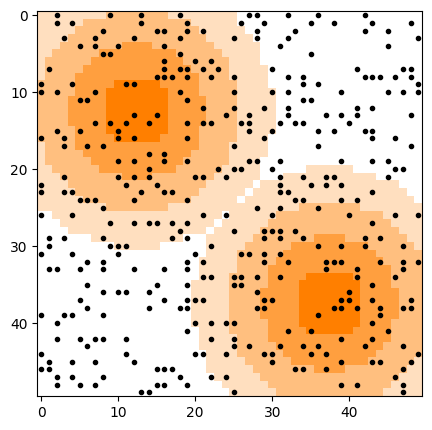

In [114]:
SuSca_RGB = convert2RBG(SuSca, RGB0, RGB1)
# print(SuSca)

plt.figure(figsize=(5, 5))
plt.imshow(SuSca_RGB)
plt.plot(Agents["X position"], Agents["Y position"], '.', color='k')
plt.show()

# print(Agents)

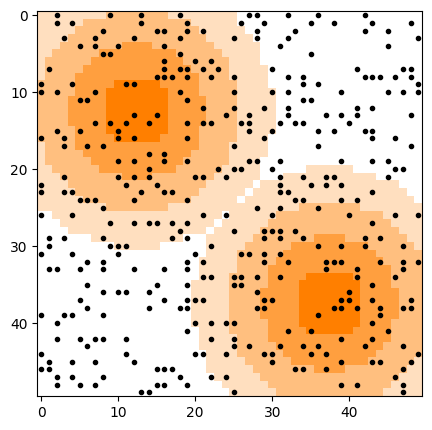

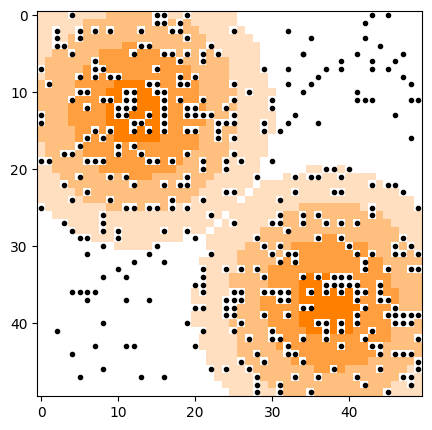

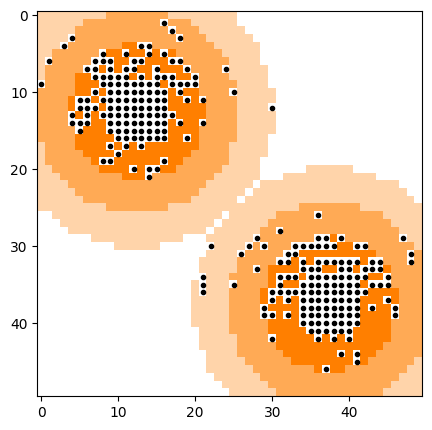

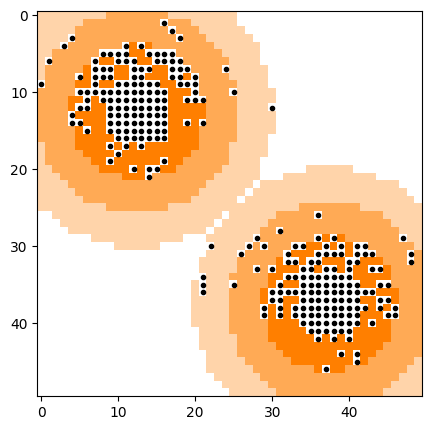

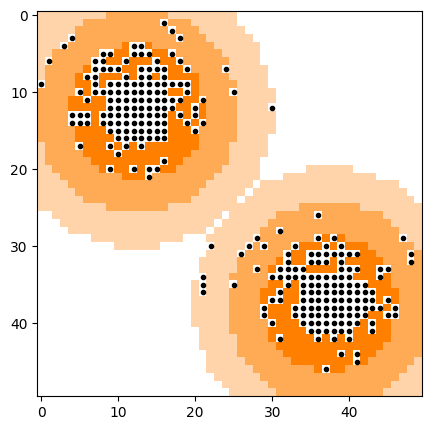

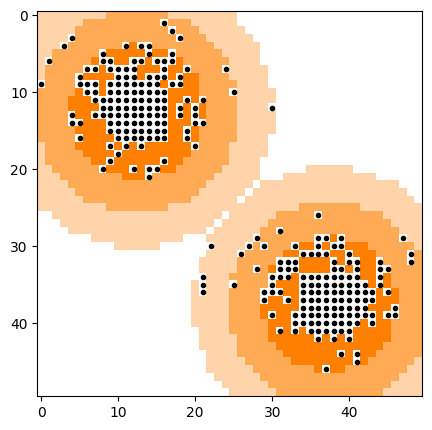

KeyboardInterrupt: 

In [115]:
SuSca_RGB = convert2RBG(SuSca, RGB0, RGB1)
# print(SuSca)

plt.figure(figsize=(5, 5))
plt.imshow(SuSca_RGB)
plt.plot(Agents["X position"], Agents["Y position"], '.', color='k')
plt.show()


    
# Create the image of the game outcome.
RGB1 = [1.0, 0.5, 0.0]  # Orange. Color for high values.
RGB0 = [1.0, 1.0, 1.0]  # White. Color for low values.

MAX_STEP = 1001
N_skip = 200
step = 0

N_alive_agents = np.zeros(MAX_STEP)

running = True  # Flag to control the loop.
while running:
    
    N_alive_agents[step] = Agents["Alive?"].sum()

    nSuSca, Agents= move_agents(SuSca, Agents) # A, V, S, M, x, y   nA, nV, nS, nM, nx, ny
    # print(nSuSca)
    if step % N_skip == 0:  
        # print(Agents) 
        SuSca_RGB = convert2RBG(nSuSca, RGB0, RGB1)

        plt.figure(figsize=(5, 5))
        plt.imshow(SuSca_RGB)
        plt.plot(Agents["X position"][Agents["Alive?"]], Agents["Y position"][Agents["Alive?"]], '.', color='k')
        plt.show()


    step += 1
    
    if step >= MAX_STEP:
        running = False


Agents1 = Agents.copy()



Compare histograms:

In [ ]:
print(A)

400


#### Metabolism

In [ ]:
# Metabolism: initial and final distribution.
m_bins = possible_m
m_bins_edges = np.arange(np.amin(possible_m) - 0.5, np.amax(possible_m) + 0.6)
m_ini_h, m_ini_e = np.histogram(M0, bins=m_bins_edges)
m_fin_h, m_fin_e = np.histogram(M1, bins=m_bins_edges)


plt.figure(figsize=(10, 5))
plt.bar(m_bins, m_ini_h, width=0.8, edgecolor='k', label='initial')
plt.bar(m_bins, m_fin_h, width=0.4, edgecolor='k', label='final')
plt.legend()
plt.xlabel('m')
plt.title('metabolism')
plt.show()





NameError: name 'M0' is not defined

#### Vision

In [ ]:
# Vision: initial and final distribution.
v_bins = possible_v
v_bins_edges = np.arange(np.amin(possible_v) - 0.5, np.amax(possible_v) + 0.6)
v_ini_h, v_ini_e = np.histogram(V0, bins=v_bins_edges)
v_fin_h, v_fin_e = np.histogram(V1, bins=v_bins_edges)


plt.figure(figsize=(10, 5))
plt.bar(v_bins, v_ini_h, width=0.8, edgecolor='k', label='initial')
plt.bar(v_bins, v_fin_h, width=0.4, edgecolor='k', label='final')
plt.legend()
plt.xlabel('v')
plt.title('vision')
plt.show()


#### Sugar

In [ ]:
# Sugar: initial and final distribution.
s_bins_i = possible_s
s_bins_edges_i = np.arange(np.amin(possible_s) - 0.5, np.amax(possible_s) + 0.6)
s_ini_h, s_ini_e = np.histogram(S0, bins=s_bins_edges_i)

plt.figure(figsize=(10, 5))
plt.bar(s_bins_i, s_ini_h, width=0.8, edgecolor='k', label='initial')
plt.legend()
plt.xlabel('s')
plt.title('sugar')
plt.show()




### Lorenz curve and Gini coefficient.

Measure of equality in wealth / resources distribution 

In [ ]:
def Lorenz_curve(s):
    """
    Function to generate the Lorenz curve from a sequence of data.
    
    Parameters
    ==========
    s : Sugar of each agent.
    """
    
    N = np.size(s)
    
    population_fraction = np.arange(N) / N
    
    s_sorted = np.sort(s)
    
    cumulative_s_fraction = np.cumsum(s_sorted) / np.sum(s_sorted)
    
    
    return cumulative_s_fraction, population_fraction

In [ ]:
L0, F0 = Lorenz_curve(S0)


plt.figure(figsize=(5, 5))
plt.plot(F0, L0, '.-', label='initial')
plt.plot([0, 1], [0, 1], '--', color='k', label='equality')
plt.legend()
plt.xlabel('F')
plt.ylabel('L')
plt.title('sugar')
plt.show()


